# Attention for Dow

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import os
import math
import random
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="ticks")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:

import torch
import itertools
import numbers
import torch.utils.data as utils
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions.multivariate_normal import MultivariateNormal as Mvnorm
from torch.utils.data import Dataset

from scipy.stats import mvn

In [4]:

import time

np.random.seed(817)
torch.manual_seed(817)
random.seed(817)

In [5]:
Dow_file="data/daily_return_ratio.csv"
file=pd.read_csv(Dow_file)
data = torch.tensor(file.iloc[:,1:30].transpose().values.astype("float32"))
datets = pd.to_datetime(file.Date)
# time seq split
train_size ,valid_size, test_size = 2601, 650, 2169
ind_M = torch.arange(train_size+valid_size)
interval = 21
jump_ind = torch.tensor(np.arange(1,np.int(np.floor(test_size/interval))+1))
jump_ind = train_size+valid_size+jump_ind*interval+200-1

In [6]:
pd.to_datetime(datets.iloc[jump_ind])


3471   2013-02-21
3492   2013-03-22
3513   2013-04-23
3534   2013-05-22
3555   2013-06-21
          ...    
5529   2021-04-26
5550   2021-05-25
5571   2021-06-24
5592   2021-07-26
5613   2021-08-24
Name: Date, Length: 103, dtype: datetime64[ns]

In [7]:
Dow_Y="data/gru_save/predY_matrix_month_time.csv"
df=pd.read_csv(Dow_Y)
df.shape

(103, 29)

In [8]:
dowalpha_gx=pd.read_csv("data/gru_save/param_matrix_S_alpha_step_one_ahead_month_time_gx_att.csv")
dowbeta_gx=pd.read_csv("data/gru_save/param_matrix_S_beta_step_one_ahead_month_time_gx_att.csv")
dowgamma_gx=pd.read_csv("data/gru_save/param_matrix_S_gamma_step_one_ahead_month_time_gx_att.csv")
dowuv = pd.read_csv("data/gru_save/UV_matrix_gx_month_time_att.csv")

dowalpha=pd.read_csv("data/gru_save/param_matrix_S_alpha_step_one_ahead_month_time_att.csv")
dowbeta=pd.read_csv("data/gru_save/param_matrix_S_beta_step_one_ahead_month_time_att.csv")
dowgamma=pd.read_csv("data/gru_save/param_matrix_S_gamma_step_one_ahead_month_time_att.csv")
dowgamma.shape

(103, 29)

In [9]:
nrow, ncol = dowgamma.shape
ncol = ncol-1

# correlation plot -- Naive GRU

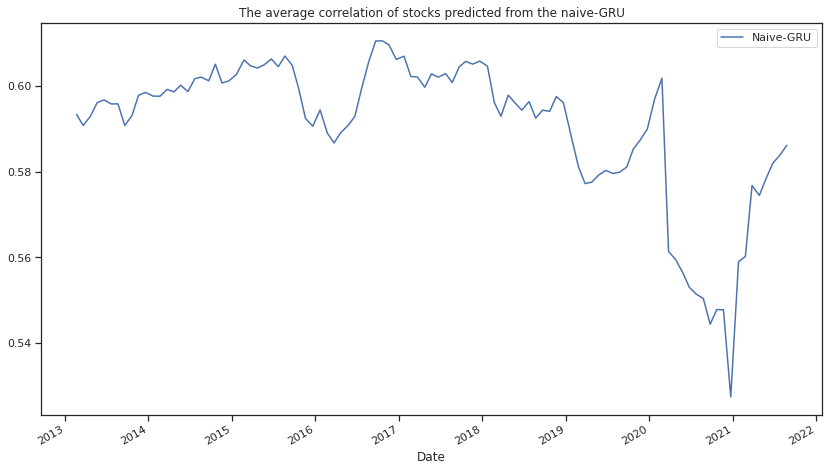

In [10]:
rho_mat = pd.DataFrame(np.zeros([nrow, ncol]))
for i in range(dowgamma.shape[1]-1):
    sigma_seq = np.sqrt((dowbeta.iloc[:,i+1])**2+(dowgamma.iloc[:,i+1])**2)
    rho_mat.iloc[:,i] = dowbeta.iloc[:,i+1]/sigma_seq
    

rho_mean = pd.DataFrame(np.mean(rho_mat,axis=1),columns=["Naive-GRU"])
rho_mean.index=pd.to_datetime(datets.iloc[jump_ind])

# correlation plot --DCC

In [11]:
dowrho_dcc=pd.read_csv('data/cvar_output/dcc_rho_month.csv',header=None)
dowrho_dcc.shape

(103, 28)

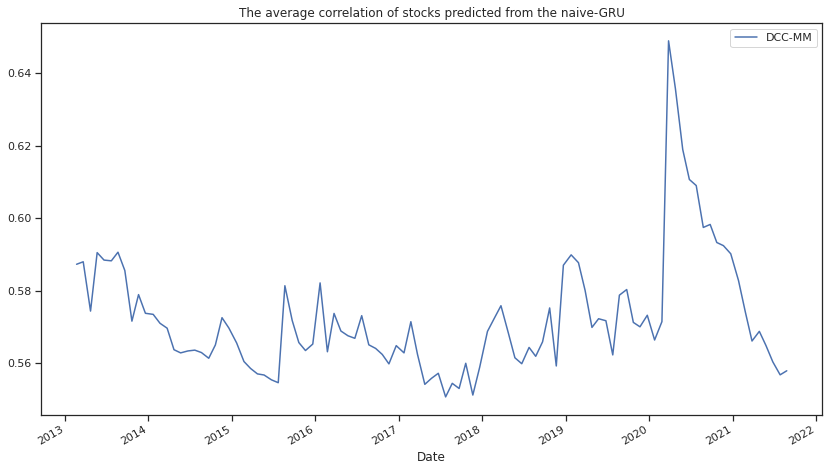

In [15]:
rho_mean = pd.DataFrame(np.mean(dowrho_dcc,axis=1),columns=["DCC-MM"])
rho_mean.index=pd.to_datetime(datets.iloc[jump_ind])

# correlation plot -- GX-GRU

In [12]:
from numpy.random import normal
def gx(x, u ,v, A):
        
    return x*((np.exp(np.log(u)*x)+np.exp(-np.log(v)*x))/A+1)


In [13]:
zm= normal(loc=0, scale=1, size=100000)

np.quantile(zm,0.025)

-1.962863303652437

In [14]:
uM,vM = dowuv.iloc[0,1:3]
gzm = gx((zm),uM,vM,4)
varYM = np.sqrt(np.var(gzm))
rho_mat_gx = pd.DataFrame(np.zeros([nrow, ncol]))


for k in range(ncol):
    j= k+1
    

    u1,v1 = dowuv.iloc[j,1:3]
    u2,v2 = dowuv.iloc[j,3:5]
    zi= normal(loc=0, scale=1, size=100000)
    gzmi = gx((zm),u1,v1,4)
    var1 = (np.var(gzmi))
    gzi = gx((zi),u2,v2,4)
    var2 = (np.var(gzi))
    
    covim = np.cov(gzm, gzmi)[0,1]

    rho_mat_gx.iloc[:,k] = dowbeta_gx.iloc[:,j]*covim/((varYM)*np.sqrt((dowbeta_gx.iloc[:,j]**2)*var1+(dowgamma_gx.iloc[:,j]**2)*var2))
    



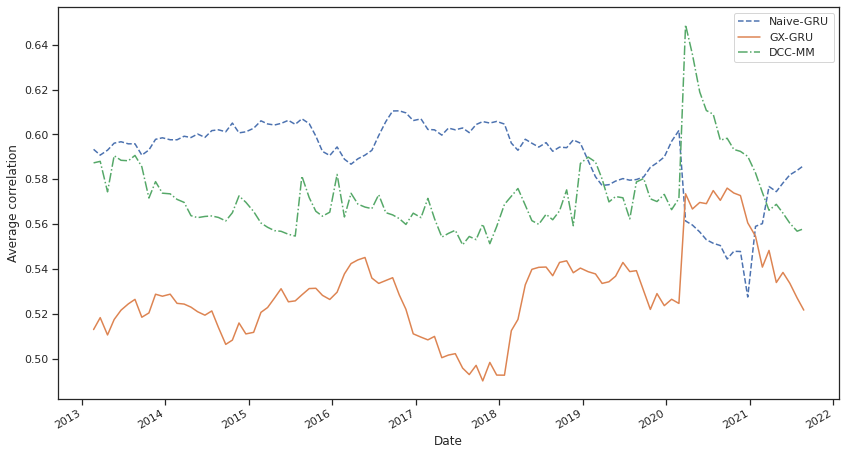

In [16]:
rho_mean = pd.DataFrame(np.mean(rho_mat,axis=1),columns=["Naive-GRU"])
rho_mean["GX-GRU"] = np.mean(rho_mat_gx,axis=1)
rho_mean["DCC-MM"] = np.mean(dowrho_dcc,axis=1)
rho_mean.index=pd.to_datetime(datets.iloc[jump_ind])
fig = rho_mean.plot(figsize=(14, 8),style=['--','-','-.'])
fig.set_ylabel("Average correlation")
fig.figure.savefig('data/visualization_output/bothgrucor.pdf')

In [23]:
uM,vM

(1.0118800401687622, 1.782348394393921)

# Kupiec test- for equally weighted portfolio

In [24]:
import scipy.stats
from scipy.stats.distributions import chi2

In [25]:
# test statistics for a vector of violations
#alpha = 0.99
alpha_seq = (np.arange(10))*0.05+0.5
alpha_seq = np.append(alpha_seq, 0.99)
# output the p-value of test
def kupic_test(x, alpha):
    c1 = sum(x)
    p1 = c1/len(x)
    c0 = len(x)-sum(x)
    p0 = c0/len(x)
    
    T = ((p1/alpha)**c1)*((p0/(1-alpha))**c0)
    T = 2*np.log(T)
    
    return chi2.sf(T,1)
# small p value means model mispecification    

In [21]:
# both tail
mean_p = np.mean(dowalpha.iloc[:,1:],axis=1)
var_p = (np.mean(dowbeta.iloc[:,1:],axis=1))**2
var_p = var_p+np.sum(dowgamma.iloc[:,1:]**2,axis=1)/(ncol**2)
var_p = np.sqrt(var_p)
r_p = np.mean(df.iloc[:,1:],axis=1)
naive_test=np.zeros(len(alpha_seq))
naive_test_lower=np.zeros(len(alpha_seq))

for l in  range(len(alpha_seq)):
    alpha = alpha_seq[l]
    #both
    q_norm = scipy.stats.norm.ppf(1-(1-alpha)/2)
    
    low_bound = mean_p-var_p*q_norm
    upper_bound = mean_p+var_p*q_norm

    vio_seq = (r_p<upper_bound)&(r_p>low_bound)
    naive_test[l] = kupic_test(vio_seq, alpha)
    # lower
    q_norm = scipy.stats.norm.ppf(alpha)
    low_bound = mean_p-var_p*q_norm

    
    vio_seq = (r_p>low_bound)
    naive_test_lower[l] = kupic_test(vio_seq, alpha)
    
    



In [22]:
naive_test

array([0.00401615, 0.00385514, 0.00332915, 0.01008208, 0.00735529,
       0.00953649, 0.01094226, 0.05650839, 0.0195462 , 0.10572841,
       0.97618403])

In [23]:
naive_test_lower

array([2.27032868e-04, 1.95750630e-03, 5.63062613e-05, 2.05895404e-04,
       2.52620577e-04, 4.32907246e-03, 4.53908985e-03, 5.65083878e-02,
       2.52605950e-01, 1.05728411e-01, 9.76184034e-01])

In [26]:
gx_test = np.zeros(ncol)
low_bound = np.zeros(nrow)
upper_bound = np.zeros(nrow)
lower_low_bound = np.zeros(nrow)
sample_gx = pd.DataFrame(np.zeros([100000,nrow]))

for k in range(ncol):
    j= k+1
    
    u1,v1 = dowuv.iloc[j,1:3]
    u2,v2 = dowuv.iloc[j,3:5]
    zi= normal(loc=0, scale=1, size=100000)
    
    gzmi = gx((zm),u1,v1,4)
    gzmi = gzmi[:,None]
    gzi = gx((zi),u2,v2,4)
    gzi = gzi[:,None]
    
    # both tail
    alpha_i = dowalpha_gx.iloc[:,j]
    beta_i = dowbeta_gx.iloc[:,j]
    gamma_i = dowgamma_gx.iloc[:,j]
    

    sample_gx = sample_gx + alpha_i[None,:] +gzmi*beta_i[None,:]+gzi*gamma_i[None,:]
    
sample_gx = sample_gx/ncol

gx_test=np.zeros(len(alpha_seq))
gx_test_lower=np.zeros(len(alpha_seq))
r_p = np.mean(df.iloc[:,1:],axis=1) 
for l in range(len(alpha_seq)):
    alpha = alpha_seq[l]
    for i in range(nrow):
 
        low_bound[i] = np.quantile(sample_gx.iloc[:,i],(1-alpha)/2)
        upper_bound[i] = np.quantile(sample_gx.iloc[:,i],1-(1-alpha)/2)  
    
        lower_low_bound[i] = np.quantile(sample_gx.iloc[:,i],(1-alpha))
    
       
    vio_seq = (r_p<upper_bound)&(r_p>low_bound)
    vio_seq_lower = (r_p>lower_low_bound)
    
    gx_test[l]  = kupic_test(vio_seq, alpha)
    gx_test_lower[l]  = kupic_test(vio_seq_lower, alpha)
gx_test, gx_test_lower 


(array([0.27796745, 0.20601122, 0.51786242, 0.2910695 , 0.6810603 ,
        0.52631761, 0.69055136, 0.68510436, 0.92116721, 0.29326058,
        0.97618403]),
 array([0.00401615, 0.00727676, 0.02153789, 0.01869911, 0.00735529,
        0.06669777, 0.15170564, 0.48897577, 0.43352477, 0.42662718,
        0.97618403]))

In [27]:
# DCC-DM

DCC_sample = pd.read_csv("data/cvar_output/Simu_return_mat_dcc_dynamic_month.csv",header=None)

DCC_sample.shape

(100000, 103)

In [28]:
low_bound = np.zeros(nrow)
upper_bound = np.zeros(nrow)
lower_low_bound = np.zeros(nrow)

DCC_test=np.zeros(len(alpha_seq))
DCC_test_lower=np.zeros(len(alpha_seq))
r_p = np.mean(df.iloc[:,1:],axis=1) 
for l in range(len(alpha_seq)):
    alpha = alpha_seq[l]
    for i in range(nrow):
 
        low_bound[i] = np.quantile(DCC_sample.iloc[:,i],(1-alpha)/2)
        upper_bound[i] = np.quantile(DCC_sample.iloc[:,i],1-(1-alpha)/2)  
    
        lower_low_bound[i] = np.quantile(DCC_sample.iloc[:,i],(1-alpha))
    
       
    vio_seq = (r_p<upper_bound)&(r_p>low_bound)
    vio_seq_lower = (r_p>lower_low_bound)
    
    DCC_test[l]  = kupic_test(vio_seq, alpha)
    DCC_test_lower[l]  = kupic_test(vio_seq_lower, alpha)
DCC_test, DCC_test_lower 

(array([0.27796745, 0.3872853 , 0.3952674 , 0.2910695 , 0.12850199,
        0.26897822, 0.24255701, 0.32484408, 0.66325099, 0.70772664,
        0.39496227]),
 array([0.06044957, 0.00727676, 0.03675191, 0.05567062, 0.08056018,
        0.03726758, 0.24255701, 0.48897577, 0.92116721, 0.23161031,
        0.11293748]))

In [23]:
# DCC-MM

DCC_sample = pd.read_csv("data/cvar_output/Simu_return_mat_dcc_dynamic_month_to_month.csv",header=None)

DCC_sample.shape

(100000, 103)

In [24]:
low_bound = np.zeros(nrow)
upper_bound = np.zeros(nrow)
lower_low_bound = np.zeros(nrow)

DCC_test=np.zeros(len(alpha_seq))
DCC_test_lower=np.zeros(len(alpha_seq))
r_p = np.mean(df.iloc[:,1:],axis=1) 
for l in range(len(alpha_seq)):
    alpha = alpha_seq[l]
    for i in range(nrow):
 
        low_bound[i] = np.quantile(DCC_sample.iloc[:,i],(1-alpha)/2)
        upper_bound[i] = np.quantile(DCC_sample.iloc[:,i],1-(1-alpha)/2)  
    
        lower_low_bound[i] = np.quantile(DCC_sample.iloc[:,i],(1-alpha))
    
       
    vio_seq = (r_p<upper_bound)&(r_p>low_bound)
    vio_seq_lower = (r_p>lower_low_bound)
    
    DCC_test[l]  = kupic_test(vio_seq, alpha)
    DCC_test_lower[l]  = kupic_test(vio_seq_lower, alpha)
DCC_test, DCC_test_lower 


(array([0.13870622, 0.0229193 , 0.14287227, 0.13835366, 0.08056018,
        0.06669777, 0.24255701, 0.48897577, 0.92116721, 0.58904119,
        0.97618403]),
 array([0.02285517, 0.00385514, 0.01208964, 0.01008208, 0.01455447,
        0.03726758, 0.08855092, 0.19912979, 0.66325099, 0.42662718,
        0.97618403]))

# Market Prediction for volatility

In [17]:
Malpha=pd.read_csv("data/gru_save/param_matrix_M_alpha_step_one_ahead_month_time_att.csv")
Mbeta=pd.read_csv("data/gru_save/param_matrix_M_beta_step_one_ahead_month_time_att.csv")

Malpha_gx=pd.read_csv("data/gru_save/param_matrix_M_alpha_step_one_ahead_month_time_gx_att.csv")
Mbeta_gx=pd.read_csv("data/gru_save/param_matrix_M_beta_step_one_ahead_month_time_gx_att.csv")

Mbeta_dcc = pd.read_csv('data/cvar_output/dcc_market_sigma.csv',header=None)

In [28]:
Mbeta_dcc.shape

(103, 1)

In [29]:
varYM

1.6745904700115506

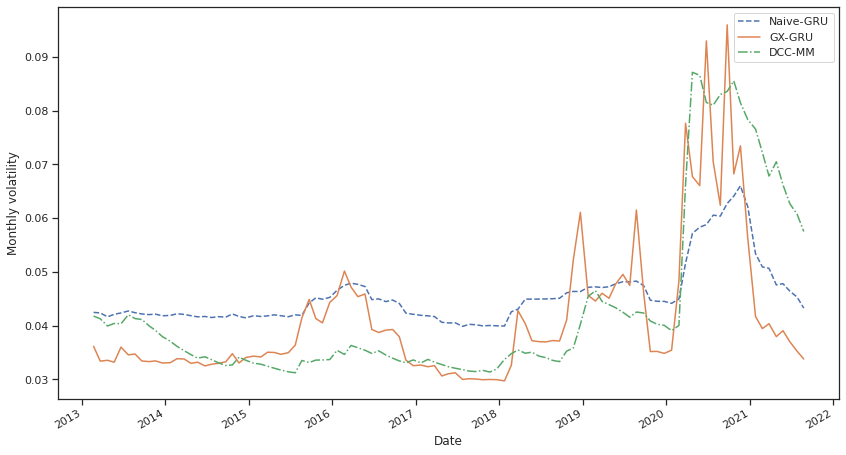

In [19]:
vol_M = pd.DataFrame(Mbeta.iloc[:,1].values,columns=["Naive-GRU"])
#vol_M["naive-GRU-alpha"]=Malpha.iloc[:,1].values
vol_M["GX-GRU"] = Mbeta_gx.iloc[:,1].values*varYM
vol_M["DCC-MM"] = Mbeta_dcc.iloc[:,0].values
vol_M.index=pd.to_datetime(datets.iloc[jump_ind])
fig = vol_M.plot(figsize=(14, 8),style=['--','-','-.'])
fig.set_ylabel("Monthly volatility")
fig.figure.savefig('data/visualization_output/bothgruMarVol.pdf')

In [37]:
np.mean(Mbeta.iloc[:,1].values),np.mean(varYM * Mbeta_gx_grad.iloc[:,1].values)

(0.04547559440776699, 0.03573395057658817)

In [36]:
min(Mbeta.iloc[:,1].values),max(Mbeta.iloc[:,1].values),min(varYM * Mbeta_gx.iloc[:,1].values),max(varYM * Mbeta_gx.iloc[:,1].values)

(0.03985571, 0.066020705, 0.029706900019910904, 0.09597217811940442)

In [25]:
varYM

1.795821629704625

# cumulation curve

In [10]:
dcc_dm_cumu = pd.read_csv('data/cvar_output/dcc_dm_cumulation.csv',header=None)
naive_cumu= pd.read_csv('data/cvar_output/naive_cumulation.csv',header=None)
gx_cumu= pd.read_csv('data/cvar_output/gx_cumulation.csv',header=None)
dcc_dm_cumu.shape, naive_cumu.shape, gx_cumu.shape

((103, 120), (103, 120), (103, 120))

In [11]:
def cumufunc(x):
    y=np.cumprod(1+x)
    return np.concatenate([[1],y])

In [12]:
jump_ind_new = torch.tensor(np.arange(0,np.int(np.floor(test_size/interval))+1))
jump_ind_new = train_size+valid_size+jump_ind_new*interval+200-1

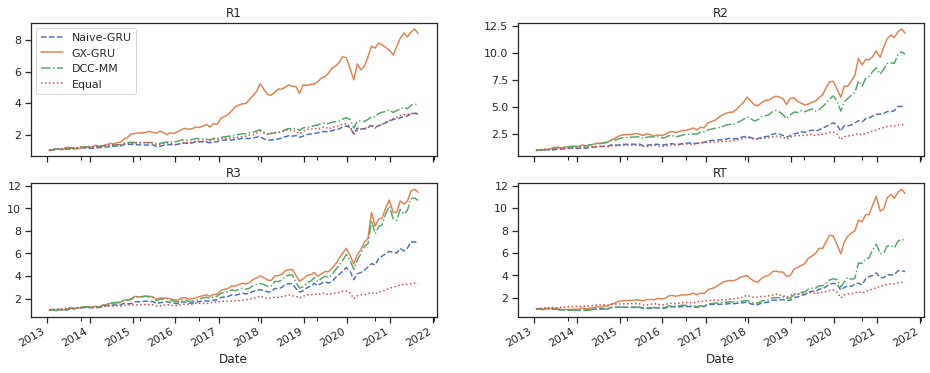

In [18]:
# q=0.90
id1=np.arange(10)*4
R1_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id1],axis=1)),columns=["Naive-GRU"])
R1_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id1],axis=1))
R1_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id1],axis=1))
R1_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R1_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

id2=np.arange(10)*4+1
R2_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id2],axis=1)),columns=["Naive-GRU"])
R2_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id2],axis=1))
R2_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id2],axis=1))
R2_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R2_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

id3=np.arange(10)*4+2
R3_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id3],axis=1)),columns=["Naive-GRU"])
R3_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id3],axis=1))
R3_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id3],axis=1))
R3_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R3_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

id4=np.arange(10)*4+3
R4_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id4],axis=1)),columns=["Naive-GRU"])
R4_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id4],axis=1))
R4_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id4],axis=1))
R4_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R4_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 6),sharex=True)
#fig.set_ylabel("Capital flow")
axes[0,0].set_title('R1')
R1_q1.plot(ax=axes[0,0],style=['--','-','-.',':'])
axes[0,1].set_title('R2')
R2_q1.plot(ax=axes[0,1],style=['--','-','-.',':'],legend=False)
axes[1,0].set_title('R3')
R3_q1.plot(ax=axes[1,0],style=['--','-','-.',':'],legend=False)
axes[1,1].set_title('RT')
R4_q1.plot(ax=axes[1,1],style=['--','-','-.',':'],legend=False)
fig.figure.savefig('data/visualization_output/cum_q1.pdf')

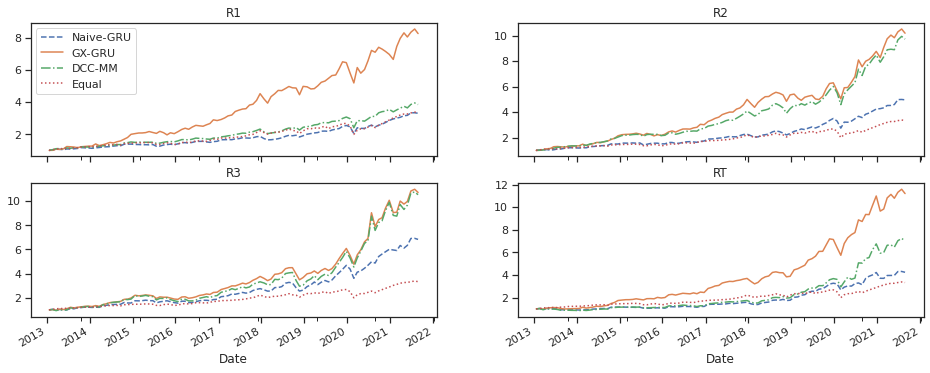

In [19]:
# q=0.95
id1=np.arange(10)*4+40
R1_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id1],axis=1)),columns=["Naive-GRU"])
R1_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id1],axis=1))
R1_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id1],axis=1))
R1_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R1_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

id2=np.arange(10)*4+1+40
R2_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id2],axis=1)),columns=["Naive-GRU"])
R2_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id2],axis=1))
R2_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id2],axis=1))
R2_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R2_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

id3=np.arange(10)*4+2+40
R3_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id3],axis=1)),columns=["Naive-GRU"])
R3_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id3],axis=1))
R3_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id3],axis=1))
R3_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R3_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

id4=np.arange(10)*4+3+40
R4_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id4],axis=1)),columns=["Naive-GRU"])
R4_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id4],axis=1))
R4_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id4],axis=1))
R4_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R4_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 6),sharex=True)
#fig.set_ylabel("Capital flow")
axes[0,0].set_title('R1')
R1_q1.plot(ax=axes[0,0],style=['--','-','-.',':'])
axes[0,1].set_title('R2')
R2_q1.plot(ax=axes[0,1],style=['--','-','-.',':'],legend=False)
axes[1,0].set_title('R3')
R3_q1.plot(ax=axes[1,0],style=['--','-','-.',':'],legend=False)
axes[1,1].set_title('RT')
R4_q1.plot(ax=axes[1,1],style=['--','-','-.',':'],legend=False)
fig.figure.savefig('data/visualization_output/cum_q2.pdf')

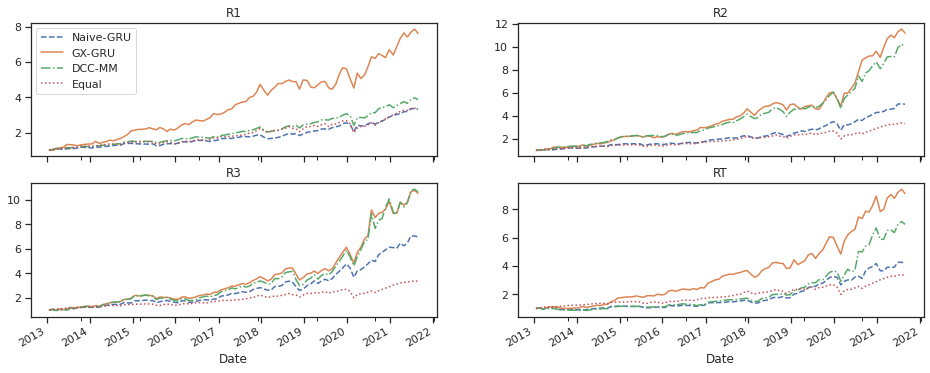

In [20]:
# q=0.99
id1=np.arange(10)*4+80
R1_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id1],axis=1)),columns=["Naive-GRU"])
R1_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id1],axis=1))
R1_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id1],axis=1))
R1_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R1_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

id2=np.arange(10)*4+1+80
R2_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id2],axis=1)),columns=["Naive-GRU"])
R2_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id2],axis=1))
R2_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id2],axis=1))
R2_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R2_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

id3=np.arange(10)*4+2+80
R3_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id3],axis=1)),columns=["Naive-GRU"])
R3_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id3],axis=1))
R3_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id3],axis=1))
R3_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R3_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

id4=np.arange(10)*4+3+80
R4_q1 = pd.DataFrame(cumufunc(np.mean(naive_cumu.iloc[:,id4],axis=1)),columns=["Naive-GRU"])
R4_q1["GX-GRU"] = cumufunc(np.mean(gx_cumu.iloc[:,id4],axis=1))
R4_q1["DCC-MM"] = cumufunc(np.mean(dcc_dm_cumu.iloc[:,id4],axis=1))
R4_q1["Equal"] = cumufunc(np.mean(df.iloc[:,1:],1))
R4_q1.index=pd.to_datetime(datets.iloc[jump_ind_new])

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 6),sharex=True)
#fig.set_ylabel("Capital flow")
axes[0,0].set_title('R1')
R1_q1.plot(ax=axes[0,0],style=['--','-','-.',':'])
axes[0,1].set_title('R2')
R2_q1.plot(ax=axes[0,1],style=['--','-','-.',':'],legend=False)
axes[1,0].set_title('R3')
R3_q1.plot(ax=axes[1,0],style=['--','-','-.',':'],legend=False)
axes[1,1].set_title('RT')
R4_q1.plot(ax=axes[1,1],style=['--','-','-.',':'],legend=False)
fig.figure.savefig('data/visualization_output/cum_q3.pdf')


